In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn import tree

In [6]:
df = pd.read_csv('/Users/34633/kagglada/complex-master-learn-and-get-your-mark/train.csv', sep=',', encoding = 'latin1')
df_test = pd.read_csv('/Users/34633/kagglada/complex-master-learn-and-get-your-mark/test.csv', sep=',', encoding = 'latin1')
df.head()

,Id,PreferedAlbum,Vinyl,AvgTime,TicketInfo,Opinion,Concert,Age,VIP,Food,Drinks,FreePass
0,01/2362,Head Hunters,False,3.055,B/140/N,"Everything worked, yet nothing surprised me. (...",NYC12-5pm,22.0,False,170.0,1.0,True
1,04/0599,Bright Size Life,True,2.510,LB/124/N,"Solid gigânothing magical, nothing awful. (N...",NYC12-5pm,9.0,False,0.0,0.0,True
2,01/3223,Head Hunters,False,0.803,CB/523/N,"Guitars were sharp, but everything else felt r...",NYC12-5pm,NaN,False,815.0,37.0,False
3,01/1966,Kind of Blue,False,0.568,A/81/XL,Feedback screamed louder than the guitars. Dis...,FL16-7pm,36.0,False,1427.0,1395.0,False
4,01/8850,Bright Size Life,False,0.034,B/580/XL,NaN,NYC12-5pm,16.0,False,1299.0,0.0,False


In [7]:
df.columns.tolist()


['Id',
 'PreferedAlbum',
 'Vinyl',
 'AvgTime',
 'TicketInfo',
 'Opinion',
 'Concert',
 'Age',
 'VIP',
 'Food',
 'Drinks',
 'FreePass']

In [8]:
df_test.shape

(2854, 11)

FreePass
True     5216
False    4900
Name: count, dtype: int64


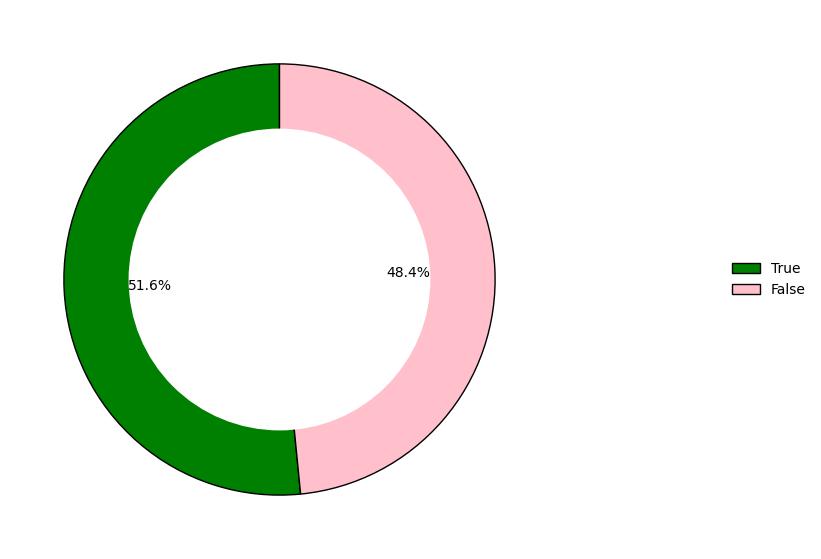

In [9]:
freepass = df['FreePass']
count_freepass = freepass.value_counts()
print(count_freepass)

labels = count_freepass.index.tolist()
colors = []
color_map = {
    True: 'green', 
    False: 'pink'
}
colors = [color_map.get(label, 'gray') for label in labels]


plt.figure(figsize=(7, 7))
plt.pie(count_freepass.values, autopct='%.1f%%', startangle=90, colors=colors,wedgeprops={'edgecolor': 'black', 'linewidth': 1})
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.legend(
    labels,
    loc="center right",
    bbox_to_anchor=(1, 0, 0.5, 1), frameon=False
)
plt.show()

In [10]:
df_sinfree = df.drop(columns=[df.columns[-1]])
df_sinfree.head()

,Id,PreferedAlbum,Vinyl,AvgTime,TicketInfo,Opinion,Concert,Age,VIP,Food,Drinks
0,01/2362,Head Hunters,False,3.055,B/140/N,"Everything worked, yet nothing surprised me. (...",NYC12-5pm,22.0,False,170.0,1.0
1,04/0599,Bright Size Life,True,2.510,LB/124/N,"Solid gigânothing magical, nothing awful. (N...",NYC12-5pm,9.0,False,0.0,0.0
2,01/3223,Head Hunters,False,0.803,CB/523/N,"Guitars were sharp, but everything else felt r...",NYC12-5pm,NaN,False,815.0,37.0
3,01/1966,Kind of Blue,False,0.568,A/81/XL,Feedback screamed louder than the guitars. Dis...,FL16-7pm,36.0,False,1427.0,1395.0
4,01/8850,Bright Size Life,False,0.034,B/580/XL,NaN,NYC12-5pm,16.0,False,1299.0,0.0


In [11]:
X = df_sinfree.values
X_train, X_val, y_train, y_val = model_selection.train_test_split(X, y, train_size=0.7, random_state=42)
clf = tree.DecisionTreeClassifier(max_depth=None)
clf.fit(X_train,y_train)
yhat = clf.predict(X_train)

NameError: name 'y' is not defined

a partir del codigo de ana (CONTINUACION)

In [12]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import f1_score, accuracy_score, precision_recall_curve

X = df.drop(columns=["Id", "FreePass"])
y = df["FreePass"].astype(int)

def prepare_data(df, is_train=True):
    df_fe = df.copy()
    
    if 'AvgTime' in df_fe.columns:
        df_fe = df_fe.drop(columns=['AvgTime'])
    
    if 'Id' in df_fe.columns and not is_train:
        ids = df_fe['Id']
        df_fe = df_fe.drop(columns=['Id'])
    else:
        ids = df.get('Id', None)

    df_fe["Food_Drinks_Sum"] = df_fe["Food"] + df_fe["Drinks"]
    df_fe["Food_Drinks_Ratio"] = df_fe["Food"] / (df_fe["Drinks"] + 1)
    df_fe["Total_Spending"] = df_fe["Food"] + df_fe["Drinks"] + df_fe.get("Vinyl", 0)
    
    df_fe['Age'] = df_fe['Age'].fillna(df_fe['Age'].median())
    df_fe['Age_Sq'] = df_fe['Age'] ** 2
    
    df_fe['Opinion'] = df_fe['Opinion'].astype(str).replace('nan', '')
    df_fe['Opinion_Length'] = df_fe['Opinion'].str.len()
    df_fe['Has_Opinion'] = (df_fe['Opinion_Length'] > 0).astype(int)
    
    keywords = ['love', 'great', 'amazing', 'excellent', 'best', 'good']
    for word in keywords:
        df_fe[f'Opinion_{word}'] = df_fe['Opinion'].str.contains(word, case=False).astype(int)
    
    df_fe = df_fe.drop(columns=['Opinion'])
    
    ticket_parts = df_fe["TicketInfo"].str.split("/", expand=True)
    df_fe["Ticket_Zone"] = ticket_parts[0]
    df_fe["Ticket_Row"] = pd.to_numeric(ticket_parts[1], errors='coerce')
    df_fe["Ticket_Size"] = ticket_parts[2]
    
    df_fe['Ticket_Row'] = df_fe['Ticket_Row'].fillna(df_fe['Ticket_Row'].median())
    df_fe['Is_Front_Row'] = (df_fe['Ticket_Row'] <= 10).astype(int)
    df_fe['Is_VIP_Zone'] = df_fe['Ticket_Zone'].str.contains('VIP', case=False, na=False).astype(int)
    
    df_fe = df_fe.drop(columns=['TicketInfo'])
    
    df_fe['Age_Group'] = pd.cut(df_fe['Age'], 
                               bins=[0, 18, 30, 45, 60, 120],
                               labels=['Kid', 'Young', 'Adult', 'Senior', 'Elder'])
    
    for col in df_fe.columns:
        if df_fe[col].dtype == 'bool':
            df_fe[col] = df_fe[col].astype(int)
            
    return df_fe, ids

X_fe, _ = prepare_data(X, is_train=True)

num_cols = X_fe.select_dtypes(include=['float64', 'int64']).columns.tolist()
cat_cols = X_fe.select_dtypes(include=['object', 'category']).columns.tolist()

num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", RobustScaler())
])

cat_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor = ColumnTransformer([
    ("num", num_pipeline, num_cols),
    ("cat", cat_pipeline, cat_cols)
])

model = HistGradientBoostingClassifier(
    max_iter=100,
    learning_rate=0.02,
    max_depth=8,
    max_leaf_nodes=40,
    min_samples_leaf=20,
    l2_regularization=1.0,
    early_stopping=True,
    n_iter_no_change=20,
    random_state=42,
    class_weight='balanced'
)

full_pipeline = Pipeline([
    ("prep", preprocessor),
    ("model", model)
])

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(full_pipeline, X_fe, y, cv=skf, scoring='accuracy')
print(f"CV Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")

X_train, X_val, y_train, y_val = train_test_split(
    X_fe, y, test_size=0.2, stratify=y, random_state=42
)

full_pipeline.fit(X_train, y_train)

y_proba_val = full_pipeline.predict_proba(X_val)[:, 1]
thresholds = np.linspace(0.1, 0.9, 80)
best_acc = 0
best_threshold = 0.5

for t in thresholds:
    acc = accuracy_score(y_val, y_proba_val > t)
    if acc > best_acc:
        best_acc = acc
        best_threshold = t

print(f"Mejor Accuracy en Val: {best_acc:.4f} usando threshold: {best_threshold:.2f}")

X_test_fe, test_ids = prepare_data(df_test, is_train=False)
X_test_fe = X_test_fe.reindex(columns=X_fe.columns, fill_value=0)

y_proba_test = full_pipeline.predict_proba(X_test_fe)[:, 1]
final_preds = (y_proba_test > best_threshold).astype(bool)

submission = pd.DataFrame({
    "Id": test_ids,
    "FreePass": final_preds
})

submission.to_csv("submission_optimized.csv", index=False)
print("Archivo 'submission_optimized.csv' generado con éxito.")

CV Accuracy: 0.8160 (+/- 0.0091)
Mejor Accuracy en Val: 0.8147 usando threshold: 0.51
Archivo 'submission_optimized.csv' generado con éxito.


In [ ]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import train_test_split

# =====================
# 1. FUNCIÓN PARA PREPARAR DATOS (USADA EN TRAIN Y TEST)
# =====================
def prepare_data(df, is_train=True):
    """Prepara datos de manera consistente para train y test"""
    df_fe = df.copy()
    
    # Eliminar columnas que no queremos
    if 'AvgTime' in df_fe.columns:
        df_fe = df_fe.drop(columns=['AvgTime'])
    
    # Guardar Id si existe (para submission)
    if 'Id' in df_fe.columns and is_train == False:
        ids = df_fe['Id']
        df_fe = df_fe.drop(columns=['Id'])
    else:
        ids = None
    
    # Features básicas
    df_fe["Food_Drinks"] = df_fe["Food"] + df_fe["Drinks"]
    df_fe["Spending"] = df_fe["Food"] * df_fe["Drinks"]
    
    # Age features
    df_fe['Age'] = df_fe['Age'].fillna(df_fe['Age'].median())
    df_fe['Is_Young'] = (df_fe['Age'] < 30).astype(int)
    df_fe['Is_Senior'] = (df_fe['Age'] > 50).astype(int)
    
    # Opinion features
    df_fe['Opinion_Length'] = df_fe['Opinion'].str.len().fillna(0)
    df_fe['Has_Opinion'] = df_fe['Opinion'].notna().astype(int)
    
    # TicketInfo
    df_fe["Ticket_Zone"] = df_fe["TicketInfo"].str.split("/").str[0]
    df_fe["Ticket_Row"] = pd.to_numeric(df_fe["TicketInfo"].str.split("/").str[1], errors='coerce')
    df_fe["Ticket_Size"] = df_fe["TicketInfo"].str.split("/").str[2]
    df_fe['Is_Front_Row'] = (df_fe['Ticket_Row'] <= 10).astype(int)
    df_fe['Is_VIP_Zone'] = df_fe['Ticket_Zone'].str.contains('VIP', case=False, na=False).astype(int)
    
    # Age Group
    df_fe['Age_Group'] = pd.cut(df_fe['Age'], 
                               bins=[0, 25, 35, 45, 55, 100],
                               labels=['<25', '25-35', '35-45', '45-55', '55+'])
    
    # Imputar categóricas
    # for col in ['PreferedAlbum', 'Concert', 'Ticket_Zone', 'Ticket_Size', 'Age_Group']:
    #     df_fe[col] = df_fe[col].fillna('Unknown')
    
    # for col in ['Vinyl', 'VIP']:
    #     df_fe[col] = df_fe[col].fillna('Unknown')
    
    # Asegurar tipos
    for col in df_fe.columns:
        if df_fe[col].dtype == 'bool':
            df_fe[col] = df_fe[col].astype(int)
    
    return df_fe, ids

# =====================
# 2. PREPARAR DATOS DE TRAIN
# =====================
print("Preparando datos de entrenamiento...")
X_fe, _ = prepare_data(X, is_train=True)

# Identificar columnas
num_cols = X_fe.select_dtypes(include=['float64', 'int64']).columns.tolist()
cat_cols = X_fe.select_dtypes(include=['object', 'category']).columns.tolist()

print(f"Train - Columnas numéricas: {len(num_cols)}")
print(f"Train - Columnas categóricas: {len(cat_cols)}")
print(f"Train - Total columnas: {len(num_cols) + len(cat_cols)}")

# =====================
# 3. CREAR PIPELINE
# =====================
num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

cat_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(
        handle_unknown="ignore",
        sparse_output=False
    ))
])

preprocessor = ColumnTransformer([
    ("num", num_pipeline, num_cols),
    ("cat", cat_pipeline, cat_cols)
])

# Pipeline completo
pipeline = Pipeline([
    ("prep", preprocessor),
    ("model", HistGradientBoostingClassifier(
        max_iter=400,
        learning_rate=0.05,
        max_depth=7,
        min_samples_leaf=20,
        l2_regularization=0.1,
        early_stopping=True,
        random_state=42,
        class_weight='balanced'
    ))
])

# =====================
# 4. ENTRENAR MODELO
# =====================
print("\nEntrenando modelo...")
X_train, X_val, y_train, y_val = train_test_split(
    X_fe, y, test_size=0.2, stratify=y, random_state=42
)

pipeline.fit(X_train, y_train)

# Evaluar
from sklearn.metrics import f1_score, accuracy_score
y_pred = pipeline.predict(X_val)
print(f"F1 Score en validation: {f1_score(y_val, y_pred):.4f}")
print(f"Accuracy en validation: {accuracy_score(y_val, y_pred):.4f}")

# =====================
# 5. PREPARAR Y PREDECIR TEST
# =====================
print("\nPreparando datos de test...")
X_test_fe, test_ids = prepare_data(df_test, is_train=False)

# Verificar que test tenga las mismas columnas que train
print(f"Test - Total columnas: {X_test_fe.shape[1]}")

# Asegurar que test tiene las mismas columnas en el mismo orden
missing_cols = set(X_fe.columns) - set(X_test_fe.columns)
extra_cols = set(X_test_fe.columns) - set(X_fe.columns)

if missing_cols:
    print(f"Columnas faltantes en test: {missing_cols}")
    # Añadir columnas faltantes con valores por defecto
    for col in missing_cols:
        X_test_fe[col] = 0 if X_fe[col].dtype in ['int64', 'float64'] else 'Unknown'

if extra_cols:
    print(f"Columnas extra en test: {extra_cols}")
    # Eliminar columnas extra
    X_test_fe = X_test_fe.drop(columns=list(extra_cols))

# Reordenar columnas para que coincidan con train
X_test_fe = X_test_fe[X_fe.columns]

print(f"Test después de ajuste - Total columnas: {X_test_fe.shape[1]}")

# =====================
# 6. HACER PREDICCIONES
# =====================
print("\nHaciendo predicciones...")
y_proba_test = pipeline.predict_proba(X_test_fe)[:, 1]

# Aplicar threshold (ajusta según lo que optimizaste)
best_threshold = 0.5
preds = (y_proba_test > best_threshold).astype(int)

# =====================
# 7. CREAR SUBMISSION
# =====================
submission = pd.DataFrame({
    "Id": test_ids,
    "FreePass": preds.astype(bool)
})

print(f"\nSubmission creado:")
print(f"Número de predicciones: {len(submission)}")
print(f"FreePass positivos: {submission['FreePass'].sum()} ({submission['FreePass'].mean()*100:.1f}%)")

# Guardar
submission.to_csv("submission_final.csv", index=False)
print("Guardado como 'submission_final.csv'")